In [2]:
import os
import numpy as np
import mne
import imageio
import h5py
#import scipy.fftpack
import matplotlib
%matplotlib inline
import pywt
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
#from scipy import signal
from matplotlib.colors import ListedColormap
import time
import seaborn as sns
#import scipy.io as sio
#from scipy.integrate import simps
import pandas as pd
#from scipy import fft
import matplotlib.mlab as mlab
import sys
sys.path.append('T:\EL_experiment\Codes\CCEP_human\Python_Analysis\py_functions')
import analys_func
from scipy.stats import norm
import LL_funcs
from scipy.stats import norm
from tkinter import filedialog
from tkinter import *
import ntpath
root = Tk()
root.withdraw()
import math
import scipy
from scipy import signal
import pylab
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
import platform
from glob import glob
from scipy.io import savemat
import basic_func as bf
import tqdm
from matplotlib.patches import Rectangle
import IO_basic as IO
import IO_func as IOF
from scipy import stats
import freq_funcs as ff
from sklearn.decomposition import NMF
import NMF_funcs as NMFf
import glob
import sklearn
from scipy.spatial import distance
cwd             = os.getcwd()


In [52]:
subj = 'EL016'
cond_folder = 'CR'  # Condition = 'Hour', 'Condition', 'Ph'

if cond_folder == 'Ph':
    cond_vals = np.arange(4)
    cond_labels = ['BM', 'BL', 'Fuma', 'BZD']
    cond_colors = ['#494159', '#594157', "#F1BF98", "#8FB996"]
    cond1 = 'Condition'  # 'condition', 'h'
    cond_folder = 'Ph'  # 'Ph', 'Sleep', 'CR'
    Condition = 'Condition'
if cond_folder == 'CR':
    Condition = 'Hour'  # Condition = 'Hour'
    cond1 = 'h'  # h (as stored in stimlist)

######## General Infos
if platform.system()=='Windows':
    sep = ','
    path_patient_analysis = 'y:\eLab\Projects\EL_experiment\Analysis\Patients\\' + subj

    path_patient    = 'T:\EL_experiment\Patients\\'+subj+'\Data\EL_experiment' # os.path.dirname(os.path.dirname(cwd))+'/Patients/'+subj
else: #'Darwin' for MAC
    path_patient    = '/Volumes/EvM_T7/PhD/EL_experiment/Patients/'+subj
    sep =';'
    
sep = ';'
Fs = 500
lbls            = pd.read_excel(path_patient + "/infos/" + subj + "_labels.xlsx", header=0, sheet_name='BP')
labels_all      = lbls.label.values
labels_clinic   = lbls.Clinic.values
labels_region   = lbls.Region.values
labels_L        = lbls.Hemisphere.values
nodes           = pd.DataFrame({'ID': labels_all, 'Region': labels_region, 'H': labels_L})
coord_all       = np.array([lbls.x.values,lbls.y.values, lbls.z.values ]).T
bad_region = np.where((labels_region=='WM')|(labels_region=='OUT')|(labels_region=='Putamen'))[0]
#if subj == 'EL006':
 #     labels_all      = lbls.Clinic.values
badchans  = pd.read_csv(path_patient_analysis + '/BrainMapping/data/badchan.csv')
bad_chans = np.unique(np.array(np.where(badchans.values[:,1:]==1))[0,:])

bad_stims = np.where(labels_region=='OUT')[0]

##all 
cond_vals   = np.arange(4)
cond_labels = ['BM', 'BL', 'Fuma', 'BZD']
cond_colors = ['#494159','#594157', "#F1BF98","#8FB996"]

In [53]:
cond_folder = 'CR'
folder = 'BrainMapping'
file_con = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\con_trial_all.csv'
con_trial    = pd.read_csv(file_con)

In [54]:
import NMF_funcs as NMFf
from sklearn.decomposition import NMF

In [55]:
metric  ='LL'
M_dir_path = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\BM_figures\\Block\\BM_' + metric + '.npy'
M_Block = np.load(M_dir_path)


In [77]:
day = np.unique(con_trial.Date)
t0 = np.min(con_trial.loc[(con_trial.Date==day[0]), 'Hour']).astype('int')
t1 = np.max(con_trial.loc[(con_trial.Date==day[-1]), 'Hour']).astype('int')
total_hour = (len(day)-1)*24 -(t0-t1)+1

if os.path.isfile(path_patient_analysis+'/BrainMapping/CR/data/time_overview.csv'):
    time_overview = pd.read_csv(path_patient_analysis+'/BrainMapping/CR/data/time_overview.csv')
else:
    time_overview = np.zeros((total_hour,5))
    b0 = np.min(con_trial.Block)
    time_overview[:,:]=np.nan
    time_overview[:,0] = np.arange(total_hour)
    i = 0
    h0 =  np.bincount(con_trial.loc[con_trial.Block==b0, 'Hour']).argmax()
    for b in np.unique(con_trial.Block):
        date = np.bincount(con_trial.loc[con_trial.Block==b, 'Date']).argmax()
        d = np.where(day==date)[0]
        i = np.bincount(con_trial.loc[con_trial.Block==b, 'Hour']).argmax() +d*24-h0
        time_overview[i,1] = d
        time_overview[i,2] = np.bincount(con_trial.loc[con_trial.Block==b, 'Hour']).argmax()
        time_overview[i,3] = b
        time_overview[i,4] = b
    time_overview = pd.DataFrame(time_overview[:,:4], columns=['ix', 'Day', 'Hour', 'Block'])   
    time_overview.insert(3,'Hour_label', 0)
    for b in np.unique(time_overview.Block):
        if b>0:
            time_overview.loc[time_overview.Block==b, 'Hour_label'] = str(int(time_overview.loc[time_overview.Block==b, 'Hour'])).zfill(2)+':00'

    time_overview.to_csv(path_patient_analysis+'/BrainMapping/CR/data/time_overview.csv', index=False, header=True)
    
# load hypnogram
file_hypno = path_patient_analysis+'/stimlist_hypnogram.csv'
if os.path.isfile(file_hypno):
    stimlist_hypno = pd.read_csv(file_hypno)
#stimlist_hypno.loc[(stimlist_hypno.ix_chron>30)&(stimlist_hypno.ix_chron<45), 'sleep'] = 0
for d in range(len(np.unique(stimlist_hypno.date))):
    stimlist_hypno.loc[stimlist_hypno.date == np.unique(stimlist_hypno.date)[d],'ix_chron']= stimlist_hypno.loc[stimlist_hypno.date == np.unique(stimlist_hypno.date)[d],'ix_h']+d*24
if not 'Hour_chron' in time_overview:
    time_overview.insert(5, 'Hour_chron', time_overview.Hour+ time_overview.Day*24)  
stimlist_hypno = stimlist_hypno[stimlist_hypno.stim_block>0]
for p in np.unique(stimlist_hypno.Prot):
    stimlist_hypno.loc[stimlist_hypno.Prot==p,'StimNum' ] = stimlist_hypno.loc[stimlist_hypno.Prot==p,'StimNum' ]-np.min(stimlist_hypno.loc[stimlist_hypno.Prot==p,'StimNum' ])

In [78]:
def get_nnmf_Epi(X, rank, it=2000):
    # remove rows that are completly equal zero
    # model = NMF(n_components=rank, init='random', random_state=50, max_iter=it)
    # W = model.fit_transform(X)
    # H = model.components_
    W = np.zeros((X.shape[0], rank))
    X0 = np.delete(X, np.where(np.mean(X, 1) == 0)[0], 0)
    # run 5 it with mult
    model = NMF(n_components=rank, init='nndsvda', max_iter=10)
    W0 = model.fit_transform(X0)
    H0 = model.components_
    # run again with best solution of first model
    model = NMF(n_components=rank, init='custom', max_iter=it, solver='mu')
    W0 = model.fit_transform(X0, W=W0, H=H0)
    H = model.components_
    W[np.where(np.mean(X, 1) > 0)[0], :] = W0

    return W,W0, H

In [58]:
## nnmf
M_B_nmf = M_Block.reshape(len(M_Block), -1)
M_B_nmf = M_B_nmf.T
M_B_nmf[np.isnan(M_B_nmf)]=0
M_B_nmf[M_B_nmf<0]=0

In [70]:
rk = 3
[W,W0, H] = get_nnmf_Epi(M_B_nmf, rk, it=2000)

c:\users\i0328442\appdata\local\programs\python\python37\lib\site-packages\sklearn\decomposition\_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 10 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [79]:
dist_groups = np.array([[0, 30], [30, 60], [60, 120]])
dist_labels = ['local (<30 mm)', 'short (<60mm)', 'long']
Fs = 500
dur = np.zeros((1, 2), dtype=np.int32)
t0 = 1
dur[0, 0] = -t0
dur[0, 1] = 3

folder = 'BrainMapping'
# dur[0,:]       = np.int32(np.sum(abs(dur)))
x_ax = np.arange(dur[0, 0], dur[0, 1], (1 / Fs))
color_elab = np.zeros((3, 3))
color_elab[0, :] = np.array([31, 78, 121]) / 255
color_elab[1, :] = np.array([189, 215, 238]) / 255
color_elab[2, :] = np.array([0.256, 0.574, 0.431])
cwd = os.getcwd()

In [65]:
stimlist_hypno.loc[stimlist_hypno.stim_block==i_b,'ix_chron']

Series([], Name: ix_chron, dtype: float64)

In [80]:

blocks_all = np.unique(con_trial.Block)
x_ax_block = np.zeros((int(np.max(blocks_all)+1),))
x_ticks_h = np.zeros((int((np.max(blocks_all)+1)/5),))
labels_hour = []
k = 0
for i_b in range((int(np.max(blocks_all)+1))):
    if i_b in blocks_all:
        x_ax_block[i_b] = stimlist_hypno.loc[stimlist_hypno.stim_block==i_b,'ix_chron'].values[0]
        if (np.mod(i_b,5) ==0):
            x_ticks_h[k] =  stimlist_hypno.loc[stimlist_hypno.stim_block==i_b,'ix_chron'].values[0]
            h = int(np.floor(stimlist_hypno.loc[stimlist_hypno.stim_block==i_b,'ix_h'].values[0]))
            labels_hour.append(str(h).zfill(2)+':00')
            k = k+1
    else:
        x_ax_block[i_b] = stimlist_hypno.loc[stimlist_hypno.stim_block==i_b+1,'ix_chron'].values[0]-1
x_ticks_h = x_ticks_h[:len(labels_hour)]

In [84]:
x_ticks_h

array([23.13666667, 28.14694444, 33.16083333, 45.03      , 50.02555556,
       55.02722222, 60.04305556, 65.03388889, 70.05333333, 75.06611111,
       80.06277778])

In [83]:
labels_hour

['23:00',
 '04:00',
 '09:00',
 '21:00',
 '02:00',
 '07:00',
 '12:00',
 '17:00',
 '22:00',
 '03:00',
 '08:00']

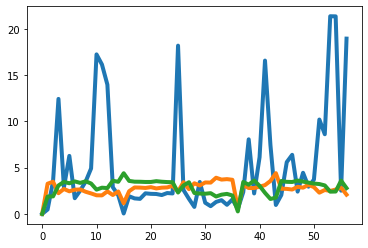

In [81]:
for i in range(rk):
    plt.plot(H[i], linewidth=4, label='H'+str(i+1))


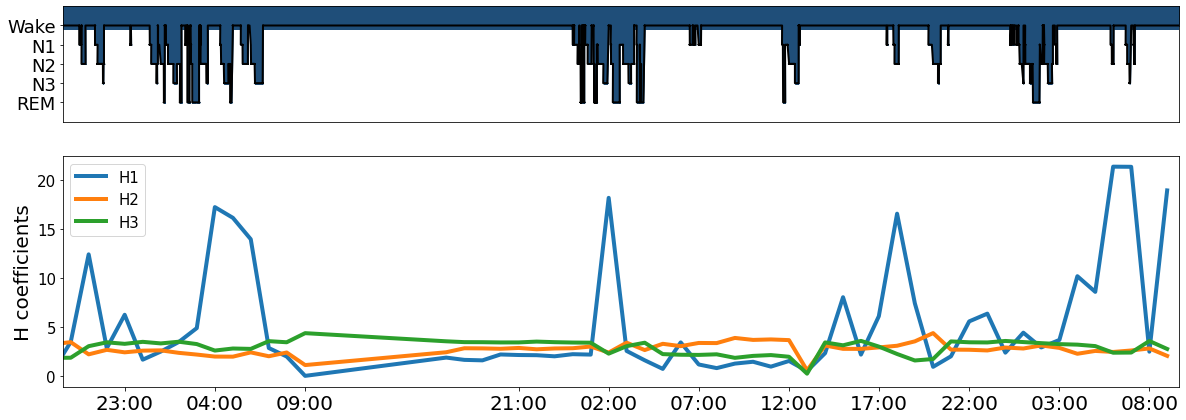

In [85]:
fig = plt.figure(figsize=(20,7))
fig.patch.set_facecolor('xkcd:white')
k = 3
gs       = fig.add_gridspec(2,1, height_ratios=[1,2])  # GridSpec(4,1, height_ratios=[1,2,1,2])
## hypnogram
ax_h = fig.add_subplot(gs[0, 0])
plt.plot(stimlist_hypno.ix_chron, stimlist_hypno.sleep, c=[0,0,0], linewidth=2)
plt.axhspan(-1, 0.2, color=color_elab[0,:])
plt.fill_between(stimlist_hypno.ix_chron,stimlist_hypno.sleep,np.zeros((len(stimlist_hypno.ix_chron),))-1, color=color_elab[0,:])
#plt.ylabel('score', fontsize=25)
plt.yticks([0,1,2,3,4], ['Wake','N1','N2','N3','REM'])
plt.ylim([-1,5])
plt.gca().invert_yaxis()
#plt.xticks(x_tick1,x_ax_h )
plt.xticks([])

plt.tick_params(axis="y", labelsize=18)
plt.xlim([np.min(np.floor(x_ax_block))+1.7, np.max(np.ceil(x_ax_block))-0.3])

ax = fig.add_subplot(gs[1, 0]) #, sharex=ax_h
for i in range(rk):
    plt.plot(x_ax_block, H[i], linewidth=4, label='H'+str(i+1))
plt.xticks(x_ticks_h,labels_hour, fontsize=20 )
plt.legend(fontsize=15)
plt.ylabel('H coefficients', fontsize=20)
plt.yticks(fontsize=15)
plt.xlim([np.min(np.floor(x_ax_block))+1.7, np.max(np.ceil(x_ax_block))-0.3])

plt.savefig(path_patient_analysis+'\\' + folder + '\\' + cond_folder +'\\BM_figures\\Block\\NMF_H.jpg')
plt.savefig(path_patient_analysis+'\\' + folder + '\\' + cond_folder +'\\BM_figures\\Block\\NMF_H.svg')
plt.show()